In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from grav_lens import get_datasets
from grav_lens.models import test_model_image

import os 

home_data = os.path.join("..","data")
train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=1500, 
    home=home_data)


Using data folder: ..\data\1


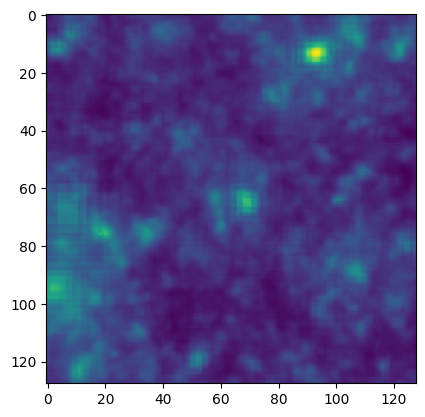

In [3]:
for X, y in train_dataset.take(1):
	plt.imshow(y[0])
	plt.plot()

In [4]:

import tensorflow as tf


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def prepare_image_for_gmm(image):
    """
    Prepara la imagen para el ajuste de Gaussian Mixture Model (GMM).

    Parámetros:
        image (numpy array): Imagen bidimensional (grayscale).

    Retorna:
        data (numpy array): Datos combinados de coordenadas e intensidades (n_samples, 3).
    """
    # Aplanar la imagen y las coordenadas
    x, y_coords = np.indices(image.shape)
    x = x.flatten()
    y_coords = y_coords.flatten()
    intensities = image.flatten()

    # Combinar las coordenadas y los valores de intensidad
    data = np.stack((x, y_coords, intensities), axis=1)
    return data


def extract_gaussian_parameters(image, n_gaussians=50):
    """
    Ajusta un modelo GMM a la imagen y extrae los parámetros de las gaussianas.

    Parámetros:
        image (numpy array): Imagen bidimensional (grayscale).
        n_gaussians (int): Número de gaussianas para ajustar el modelo.

    Retorna:
        means (numpy array): Medias de las gaussianas.
        covariances (numpy array): Covarianzas de las gaussianas.
        weights (numpy array): Pesos de las gaussianas.
    """
    # Preparar los datos para el ajuste
    data = prepare_image_for_gmm(image)

    # Ajustar el modelo GMM
    gmm = GaussianMixture(n_components=n_gaussians, covariance_type='full').fit(data)

    # Extraer los parámetros
    means = gmm.means_  # Medias de las gaussianas
    covariances = gmm.covariances_  # Covarianzas de las gaussianas
    weights = gmm.weights_  # Pesos de mezcla

    return means, covariances, weights


def gaussian_2d(x, y, mux, muy, sigma_x, sigma_y, weight):
    """
    Genera una Gaussiana bidimensional.

    Parámetros:
        x, y (numpy array): Coordenadas de la cuadrícula.
        mux, muy (float): Medias en x e y.
        sigma_x, sigma_y (float): Desviaciones estándar en x e y.
        weight (float): Peso de la gaussiana.

    Retorna:
        (numpy array): Imagen generada de la gaussiana.
    """
    return weight * np.exp(-((x - mux) ** 2 / (2 * sigma_x ** 2) + (y - muy) ** 2 / (2 * sigma_y ** 2)))


def reconstruct_image_from_gaussians(image, means, covariances, weights, n_gaussians):
    """
    Reconstruye una imagen a partir de los parámetros de las gaussianas ajustadas.

    Parámetros:
        image (numpy array): Imagen bidimensional original (grayscale).
        means (numpy array): Medias de las gaussianas.
        covariances (numpy array): Covarianzas de las gaussianas.
        weights (numpy array): Pesos de las gaussianas.
        n_gaussians (int): Número de gaussianas.

    Retorna:
        reconstructed_image (numpy array): Imagen reconstruida.
    """
    # Crear una cuadrícula de coordenadas
    x_grid, y_grid = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing='ij')

    # Inicializar la imagen reconstruida
    reconstructed_image = np.zeros_like(image)

    # Reconstruir la imagen desde las gaussianas ajustadas
    for i in range(n_gaussians):
        mux, muy, intensity = means[i]
        sigma_x, sigma_y = np.sqrt(covariances[i][0, 0]), np.sqrt(covariances[i][1, 1])
        weight = weights[i]

        # Generar la gaussiana correspondiente
        gaussian = gaussian_2d(x_grid, y_grid, mux, muy, sigma_x, sigma_y, weight)
        reconstructed_image += gaussian

    return reconstructed_image


def plot_comparison(original_image, reconstructed_image):
    """
    Grafica la imagen original y la imagen reconstruida una al lado de la otra.

    Parámetros:
        original_image (numpy array): Imagen original.
        reconstructed_image (numpy array): Imagen reconstruida.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Imagen original
    axes[0].imshow(original_image, cmap='viridis')
    axes[0].set_title("Imagen Original")
    axes[0].axis('off')
    
    # Imagen reconstruida
    axes[1].imshow(reconstructed_image, cmap='viridis')
    axes[1].set_title("Imagen Reconstruida")
    axes[1].axis('off')
    
    plt.show()



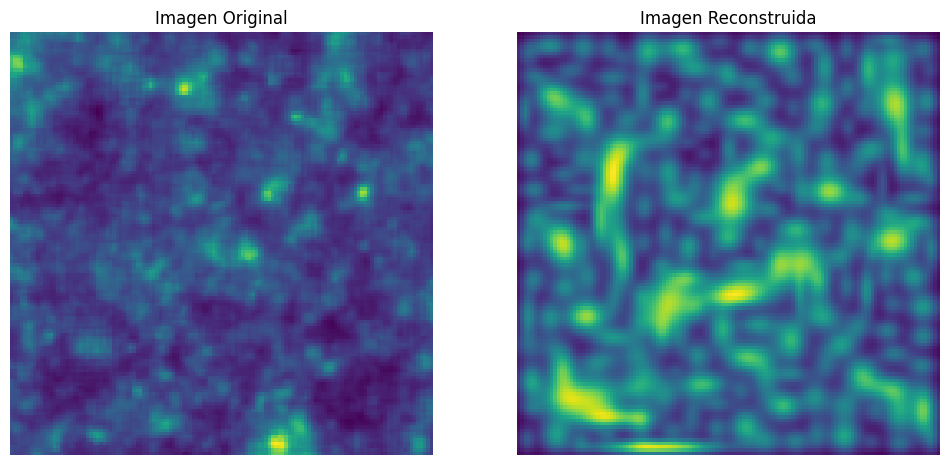

In [17]:


# ---- Ejemplo de uso ----

# Obtener la imagen desde el dataset
for X, y in train_dataset.take(1):
    original_image = y[0, :, :, 0].numpy()  # Imagen original en formato numpy

# Extraer los parámetros de las gaussianas de la imagen
n_gaussians = 200  # Número de gaussianas
means, covariances, weights = extract_gaussian_parameters(original_image, n_gaussians=n_gaussians)

# Reconstruir la imagen usando los parámetros obtenidos
reconstructed_image = reconstruct_image_from_gaussians(original_image, means, covariances, weights, n_gaussians=n_gaussians)

# Mostrar la imagen original y la reconstruida lado a lado
plot_comparison(original_image, reconstructed_image)


# Hacerlo por niveles

Teniendo tanto ruido por detras,  es necesario simplificar la cantidad de gaussianas para que el modelo sea capaz de inferir mejor, por ello vamos a tomar un threshold inicial, a manera de filtrar

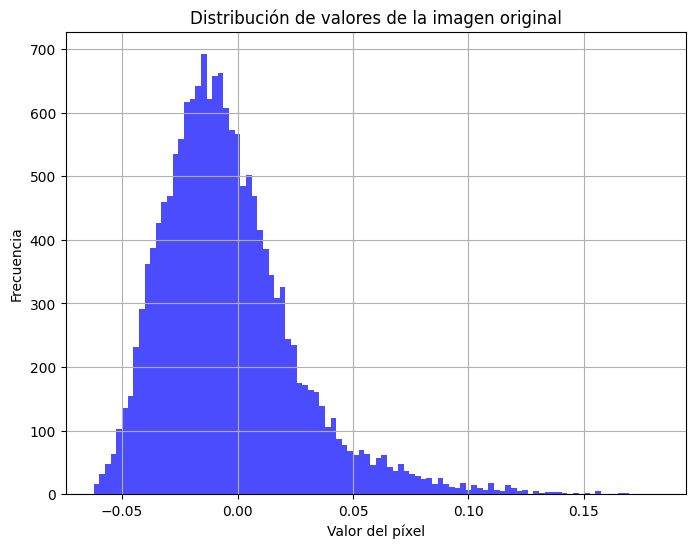

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def generate_value_distribution(image, bins=50):
    """
    Genera la distribución de los valores de una imagen.

    Parámetros:
        image (numpy array): Imagen en formato numpy array (puede ser 2D o 3D).
        bins (int): Número de bins en el histograma.

    Retorna:
        hist (numpy array): Los valores del histograma.
        bin_edges (numpy array): Los bordes de los bins en el histograma.
    """
    # Aplanar la imagen si es 2D o 3D
    flattened_image = image.flatten()

    # Generar el histograma de los valores
    hist, bin_edges = np.histogram(flattened_image, bins=bins)
    
    return hist, bin_edges


def plot_value_distribution(image, bins=50, title="Distribución de valores de la imagen"):
    """
    Crea un gráfico de la distribución de los valores de la imagen.

    Parámetros:
        image (numpy array): Imagen en formato numpy array (puede ser 2D o 3D).
        bins (int): Número de bins en el histograma.
        title (str): Título de la gráfica.
    """
    # Generar la distribución de los valores
    hist, bin_edges = generate_value_distribution(image, bins=bins)

    # Crear la gráfica del histograma
    plt.figure(figsize=(8, 6))
    plt.hist(bin_edges[:-1], bin_edges, weights=hist, color='blue', alpha=0.7)
    
    # Añadir detalles a la gráfica
    plt.title(title)
    plt.xlabel("Valor del píxel")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()


# ---- Ejemplo de uso ----

# Obtener la imagen desde el dataset
for X, y in train_dataset.take(1):
    image = y[0, :, :, 0].numpy()  # Imagen de un solo canal en formato numpy

# Graficar la distribución de los valores
plot_value_distribution(image, bins=100, title="Distribución de valores de la imagen original")


In [43]:

def calculate_image_stats(image):
    """
    Calcula la media y la desviación estándar de los valores de una imagen.

    Parámetros:
        image (numpy array): Imagen en formato numpy array (2D o 3D).

    Retorna:
        mean_value (float): Media de los valores de la imagen.
        std_value (float): Desviación estándar de los valores de la imagen.
    """
    mean_value = np.mean(image)
    std_value = np.std(image)
    
    return mean_value, std_value


def apply_threshold(image, mean_value, std_value, threshold=1.0):
    """
    Aplica un umbral a la imagen basado en la media y la desviación estándar.

    Parámetros:
        image (numpy array): Imagen en formato numpy array.
        mean_value (float): Media de los valores de la imagen.
        std_value (float): Desviación estándar de los valores de la imagen.
        threshold (float): Factor de umbral para definir el rango de valores que se mantendrán.

    Retorna:
        image_thresholded (numpy array): Imagen con valores filtrados.
    """
    lower_bound = mean_value - threshold * std_value
    upper_bound = mean_value + threshold * std_value
    
    # Filtrar la imagen utilizando el umbral
    image_thresholded = np.where((image >= lower_bound) & (image <= upper_bound), 0 , image)
    
    return image_thresholded



In [44]:
# ---- Ejemplo de uso ----
for X, y in train_dataset.take(1):
    image = y[0, :, :, 0].numpy()  # Imagen de un solo canal en formato numpy

# Calcular estadísticas de la imagen
mean_value, std_value = calculate_image_stats(image)
print(f"Media: {mean_value}, Desviación estándar: {std_value}")

# Aplicar threshold para reducir el ruido
image_thresholded = apply_threshold(image, mean_value, std_value, threshold=2.0)


Media: -0.02062601037323475, Desviación estándar: 0.02641364000737667


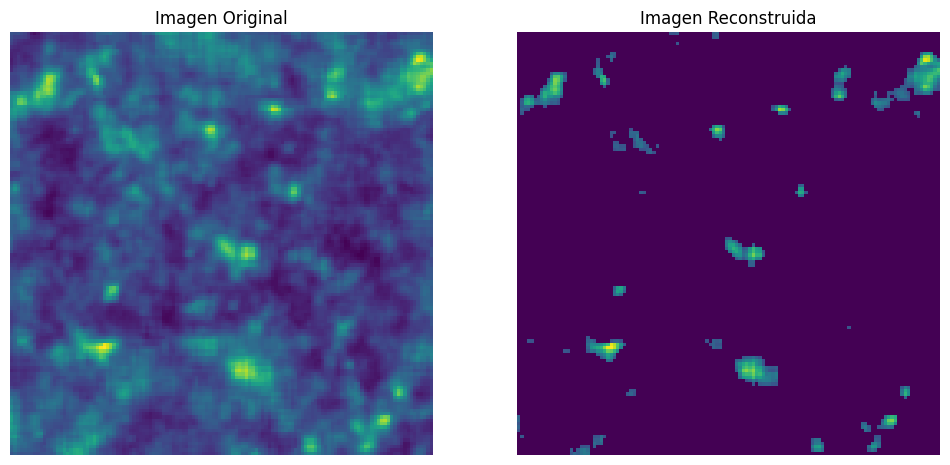

In [45]:
plot_comparison(image, image_thresholded)

# FFT y Marginal

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from sklearn.mixture import GaussianMixture

def apply_fft(image, threshold=0.1):
    """
    Aplica la Transformada Rápida de Fourier (FFT) para simplificar la imagen y eliminar el ruido.

    Parámetros:
        image (numpy array): Imagen en formato numpy array.
        threshold (float): Umbral para eliminar componentes de frecuencia bajas.

    Retorna:
        image_filtered (numpy array): Imagen filtrada con FFT.
    """
    # Aplicar la FFT a la imagen
    fft_image = fft2(image)
    
    # Eliminar componentes de baja frecuencia
    fft_image[np.abs(fft_image) < threshold * np.max(np.abs(fft_image))] = 0
    
    # Invertir la FFT para reconstruir la imagen
    image_filtered = np.abs(ifft2(fft_image))
    
    return image_filtered



# ---- Ejemplo de uso ----

for X, y in train_dataset.take(1):
    image = y[0, :, :, 0].numpy()  # Imagen de un solo canal en formato numpy

# Aplicar la FFT para simplificar la imagen y eliminar ruido
image_filtered = apply_fft(image, threshold=0.1)



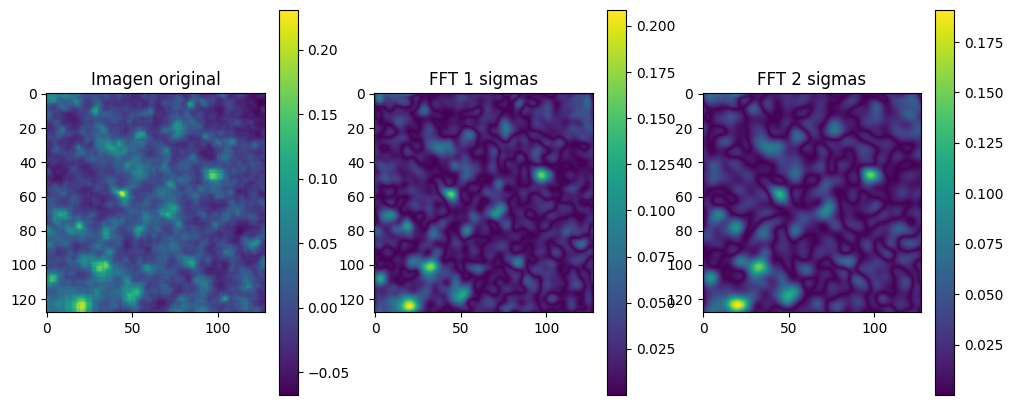

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2

def fft_filter_image(image, threshold_factor=1):
    """
    Aplica FFT a la imagen, filtra las frecuencias mayores a un umbral (definido por la desviación estándar),
    y devuelve la imagen filtrada usando la inversa de la FFT.

    Parámetros:
        image (numpy array): Imagen en formato numpy array (2D).
        threshold_factor (float): Factor que define el umbral como múltiplo de la desviación estándar (por defecto 1).

    Retorna:
        filtered_image (numpy array): Imagen reconstruida después del filtrado en frecuencia.
    """
    # Aplicar la FFT a la imagen
    fft_image = fft2(image)
    
    # Obtener los valores absolutos de las frecuencias
    values = np.abs(fft_image)
    
    # Calcular media y desviación estándar de los valores de frecuencia
    mean_value = values.mean()
    std_value = values.std()

    # Filtrar las frecuencias que sean mayores al umbral (media + 1 * desviación estándar)
    threshold = mean_value + threshold_factor * std_value
    
    # Crear una máscara para filtrar las frecuencias menores al umbral
    filtered_fft_image = np.where(values > threshold, fft_image, 0)

    # Aplicar la inversa de la FFT para reconstruir la imagen
    filtered_image = np.abs(ifft2(filtered_fft_image))

    return filtered_image


# --- Ejemplo de uso ---

# Mostrar imagen original
for X, y in train_dataset.take(1):
    image = y[0, :, :, 0].numpy()  # Imagen de un solo canal en formato numpy

plt.figure(figsize=(12, 5))


plt.subplot(1, 3, 1)
plt.imshow(image, cmap='viridis')
plt.title("Imagen original")
plt.colorbar()

# Aplicar el filtro FFT
filtered_image = fft_filter_image(image, threshold_factor=1)

# Mostrar la imagen filtrada
plt.subplot(1, 3, 2)
plt.imshow(filtered_image, cmap='viridis')
plt.title("FFT 1 sigmas")
plt.colorbar()

# Aplicar el filtro FFT
filtered_image = fft_filter_image(image, threshold_factor=2)

# Mostrar la imagen filtrada
plt.subplot(1, 3, 3)
plt.imshow(filtered_image, cmap='viridis')
plt.title("FFT 2 sigmas")
plt.colorbar()

plt.show()



Media: 0.02095545455813408, Desviación estándar: 0.018401792272925377


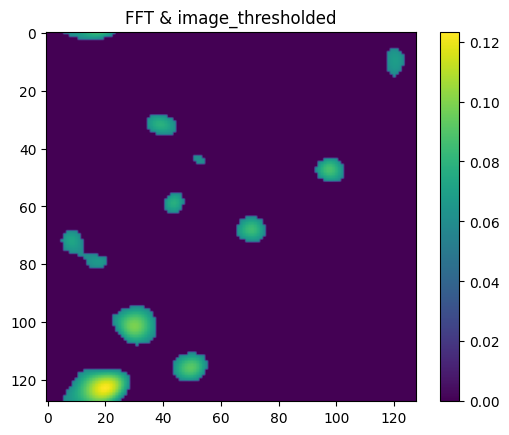

In [51]:

# Calcular estadísticas de la imagen
mean_value, std_value = calculate_image_stats(filtered_image)
print(f"Media: {mean_value}, Desviación estándar: {std_value}")

# Aplicar threshold para reducir el ruido
image_thresholded = apply_threshold(filtered_image, mean_value, std_value, threshold=2.0)

plt.imshow(image_thresholded, cmap='viridis')
plt.title("FFT & image_thresholded")
plt.colorbar()

plt.show()


# Probar el orden
FFT y corte

Media: 0.02095545455813408, Desviación estándar: 0.018401792272925377


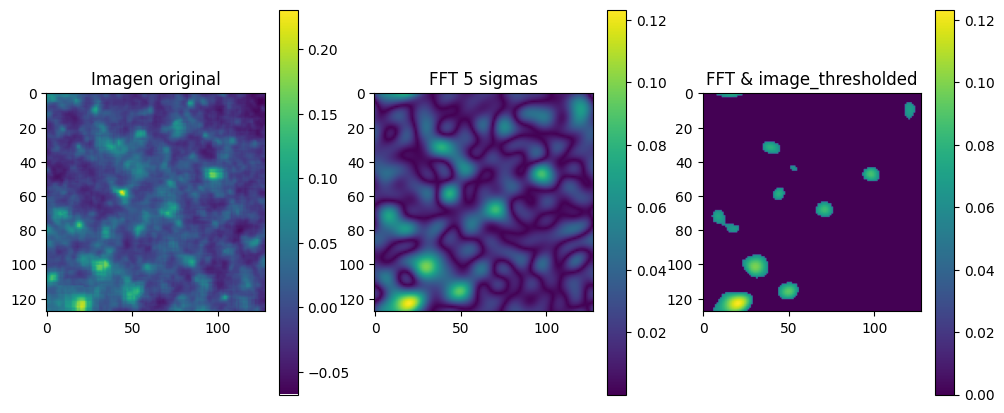

In [53]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='viridis')
plt.title("Imagen original")
plt.colorbar()

# Aplicar el filtro FFT
filtered_image = fft_filter_image(image, threshold_factor=5)


# Mostrar la imagen filtrada
plt.subplot(1, 3, 2)
plt.imshow(filtered_image, cmap='viridis')
plt.title("FFT 5 sigmas")
plt.colorbar()


# Aplicar el filtro FFT
# Calcular estadísticas de la imagen
plt.subplot(1, 3, 3)
mean_value, std_value = calculate_image_stats(filtered_image)
print(f"Media: {mean_value}, Desviación estándar: {std_value}")

# Aplicar threshold para reducir el ruido
image_thresholded = apply_threshold(filtered_image, mean_value, std_value, threshold=2.0)

plt.imshow(image_thresholded, cmap='viridis')
plt.title("FFT & image_thresholded")
plt.colorbar()


plt.show()

Corte y FFT

Media: 0.007129425182938576, Desviación estándar: 0.03249654546380043


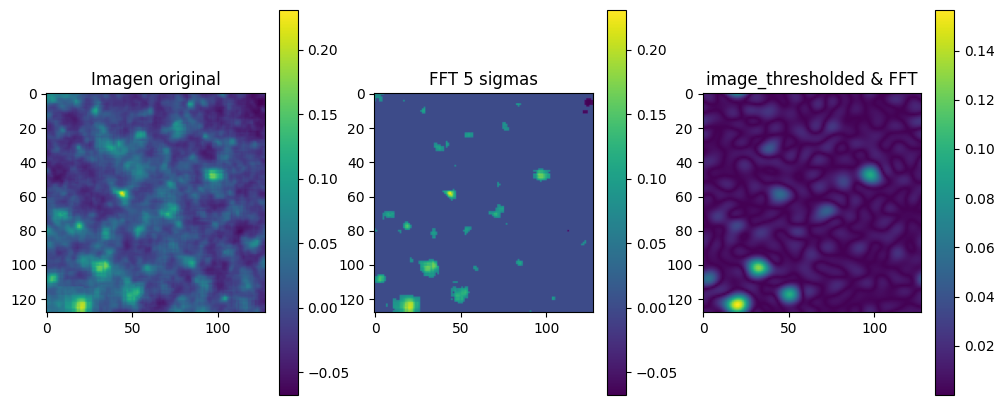

In [54]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='viridis')
plt.title("Imagen original")
plt.colorbar()


mean_value, std_value = calculate_image_stats(image)
print(f"Media: {mean_value}, Desviación estándar: {std_value}")

# Aplicar threshold para reducir el ruido
image_thresholded = apply_threshold(image, mean_value, std_value, threshold=2.0)


# Mostrar la imagen filtrada
plt.subplot(1, 3, 2)
plt.imshow(image_thresholded, cmap='viridis')
plt.title("FFT 5 sigmas")
plt.colorbar()


# Aplicar el filtro FFT
# Calcular estadísticas de la imagen
plt.subplot(1, 3, 3)


# Aplicar el filtro FFT
filtered_image = fft_filter_image(image_thresholded, threshold_factor=5)

plt.imshow(filtered_image, cmap='viridis')
plt.title("image_thresholded & FFT")
plt.colorbar()


plt.show()

# Probando el Pipeline

In [71]:
import numpy as np
from scipy.fftpack import fft2, ifft2
from sklearn.mixture import GaussianMixture

def fft_filter_image(image, threshold_factor=1):
    """
    Aplica FFT a la imagen, filtra las frecuencias mayores a un umbral (definido por la desviación estándar),
    y devuelve la imagen filtrada usando la inversa de la FFT.
    """
    # Aplicar la FFT a la imagen
    fft_image = fft2(image)
    
    # Obtener los valores absolutos de las frecuencias
    values = np.abs(fft_image)
    
    # Calcular media y desviación estándar de los valores de frecuencia
    mean_value = values.mean()
    std_value = values.std()

    # Filtrar las frecuencias que sean mayores al umbral
    threshold = mean_value + threshold_factor * std_value
    filtered_fft_image = np.where(values > threshold, fft_image, 0)

    # Aplicar la inversa de la FFT para reconstruir la imagen
    filtered_image = np.abs(ifft2(filtered_fft_image))

    return filtered_image

def calculate_image_stats(image):
    """
    Calcula la media y la desviación estándar de la imagen.
    """
    mean_value = np.mean(image)
    std_value = np.std(image)
    return mean_value, std_value



def apply_threshold(image, mean_value, std_value, threshold=1.0):
    """
    Aplica un umbral a la imagen basado en la media y la desviación estándar.

    Parámetros:
        image (numpy array): Imagen en formato numpy array.
        mean_value (float): Media de los valores de la imagen.
        std_value (float): Desviación estándar de los valores de la imagen.
        threshold (float): Factor de umbral para definir el rango de valores que se mantendrán.

    Retorna:
        image_thresholded (numpy array): Imagen con valores filtrados.
    """
    lower_bound = mean_value - threshold * std_value
    upper_bound = mean_value + threshold * std_value
    
    # Filtrar la imagen utilizando el umbral
    image_thresholded = np.where((image >= lower_bound) & (image <= upper_bound), 0 , image)
    
    return image_thresholded



def fit_gaussian_mixture(image, n_gaussians=5):
    """
    Ajusta un modelo Gaussian Mixture a la imagen.
    """
    # Convertir la imagen a un formato adecuado para el GMM
    x, y_coords = np.indices(image.shape)
    x = x.flatten()
    y_coords = y_coords.flatten()
    intensities = image.flatten()

    data = np.stack((x, y_coords, intensities), axis=1)

    # Ajustar el modelo Gaussian Mixture
    gmm = GaussianMixture(n_components=n_gaussians, covariance_type='full').fit(data)

    return gmm, gmm.means_, gmm.covariances_, gmm.weights_

def process_image_pipeline(image, threshold_factor=1, n_gaussians=5, threshold_value=2.0):
    """
    Ejecuta el pipeline completo: filtro FFT, thresholding, y ajuste de Gaussian Mixture.
    """
    # Paso 1: Filtrar la imagen usando FFT
    filtered_image = fft_filter_image(image, threshold_factor)

    # Paso 2: Calcular estadísticas de la imagen filtrada
    mean_value, std_value = calculate_image_stats(filtered_image)

    # Paso 3: Aplicar un threshold para eliminar ruido
    image_thresholded = apply_threshold(filtered_image, mean_value, std_value, threshold=threshold_value)

    # Paso 4: Ajustar un modelo Gaussian Mixture Model (GMM) a la imagen filtrada y thresholded
    gmm, means, covariances, weights = fit_gaussian_mixture(image_thresholded, n_gaussians)

    return {
        'filtered_image': filtered_image,
        'image_thresholded': image_thresholded,
        'gmm': gmm,
        'means': means,
        'covariances': covariances,
        'weights': weights
    }

# --- Ejemplo de uso del pipeline ---
for X, y in train_dataset.take(1):
    image = y[0, :, :, 0].numpy()  # Extraer una imagen del dataset

result = process_image_pipeline(image, threshold_factor=4, n_gaussians=5, threshold_value=2.0)

# Obtener los resultados del GMM
means = result['means']
covariances = result['covariances']
weights = result['weights']

# Mostrar algunos resultados
print("Medias de las gaussianas:", means)
print("Pesos de las gaussianas:", weights)


Medias de las gaussianas: [[6.88792041e+01 9.75649739e+01 0.00000000e+00]
 [9.81212910e+01 3.14022589e+01 0.00000000e+00]
 [1.07641067e+02 7.44879263e+01 7.77852988e-02]
 [3.52542079e+01 3.99473743e+01 0.00000000e+00]
 [2.20751701e+01 1.05907463e+02 7.40751381e-02]]
Pesos de las gaussianas: [0.40483031 0.20867266 0.02417029 0.34450456 0.01782217]


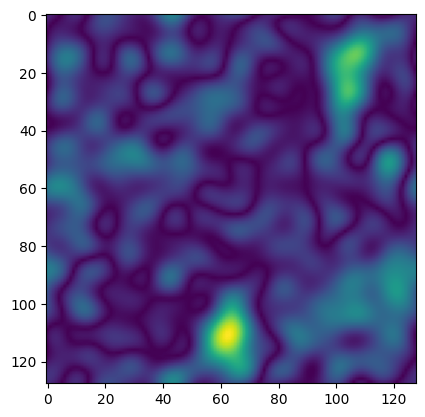

In [72]:
plt.imshow(result["filtered_image"])

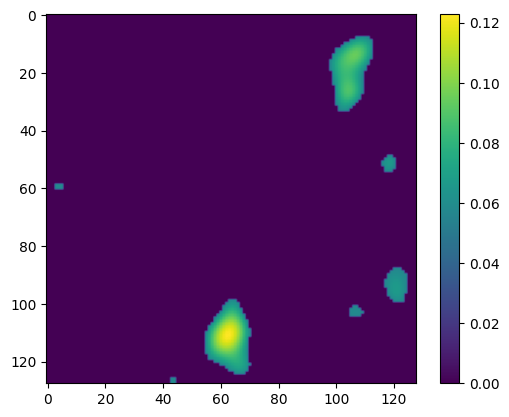

In [75]:
plt.imshow(result["image_thresholded"], cmap='viridis')
plt.colorbar()
plt.show()

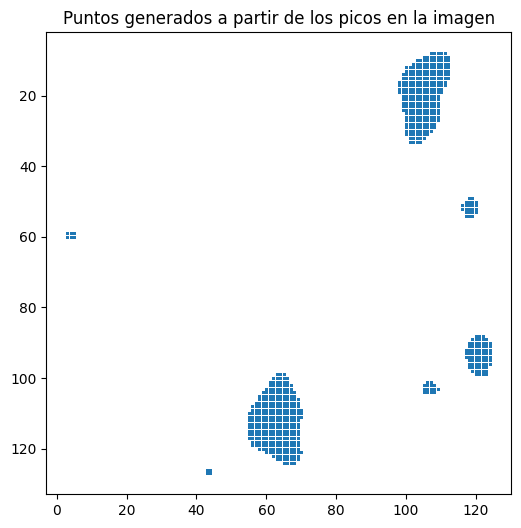

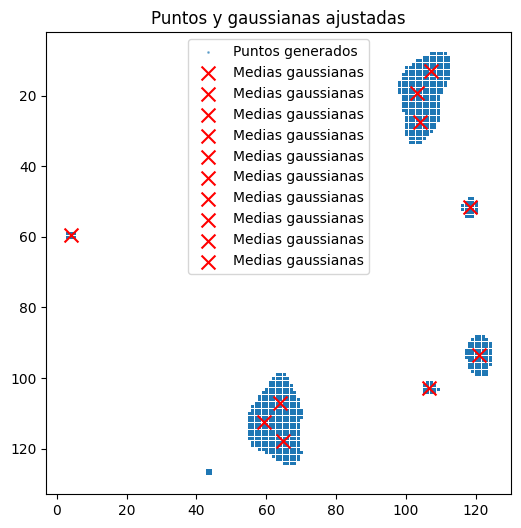

In [76]:
import numpy as np
import matplotlib.pyplot as plt

def generate_points_from_image(image, scale_factor=1000):
    """
    Genera puntos (x, y) a partir de una imagen, donde la cantidad de puntos es proporcional a la intensidad del pixel.
    
    Parámetros:
        image (numpy array): Imagen en formato numpy array (2D).
        scale_factor (int): Factor de escala para determinar cuántos puntos generar proporcionalmente al valor del pixel.
        
    Retorna:
        points (list): Lista de coordenadas (x, y) generadas a partir de los valores de los píxeles.
    """
    points = []
    # Recorrer la imagen y generar puntos proporcionales al valor del pixel
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            value = image[i, j]
            if value > 0:  # Solo considerar los picos no nulos
                n_points = int(value * scale_factor)
                points.extend([(i, j)] * n_points)  # Agregar (i, j) proporcionalmente al valor del pixel
    
    return np.array(points)

# --- Uso del código ---
image_thresholded = result["image_thresholded"]  # Esta es la imagen que quieres discretizar
scale_factor = 1000  # Factor para generar puntos proporcionales a los valores de intensidad

# Generar los puntos a partir de la imagen
points = generate_points_from_image(image_thresholded, scale_factor=scale_factor)

# Visualización de los puntos generados
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 1], points[:, 0], s=1, alpha=0.5)
plt.gca().invert_yaxis()  # Invertir eje y para que coincida con la imagen
plt.title("Puntos generados a partir de los picos en la imagen")
plt.show()

# --- Ajustar GMM a los puntos generados ---
from sklearn.mixture import GaussianMixture

n_gaussians = 10  # Número de gaussianas para ajustar
gmm = GaussianMixture(n_components=n_gaussians, covariance_type='full').fit(points)

# Visualizar las gaussianas ajustadas
means = gmm.means_
covariances = gmm.covariances_
weights = gmm.weights_

# Visualización de las gaussianas ajustadas sobre los puntos
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 1], points[:, 0], s=1, alpha=0.5, label="Puntos generados")

# Dibujar las gaussianas ajustadas
for mean, cov in zip(means, covariances):
    plt.scatter(mean[1], mean[0], color='red', s=100, marker='x', label="Medias gaussianas")

plt.gca().invert_yaxis()  # Invertir eje y para que coincida con la imagen
plt.title("Puntos y gaussianas ajustadas")
plt.legend()
plt.show()


In [81]:
def reconstruct_image_from_gmm(image_shape, means, covariances, weights):
    """
    Reconstruye la imagen a partir de los parámetros del GMM.
    
    Parámetros:
        image_shape (tuple): La forma de la imagen (ancho, alto).
        means (numpy array): Medias de las gaussianas.
        covariances (numpy array): Covarianzas de las gaussianas.
        weights (numpy array): Pesos de mezcla de las gaussianas.
    
    Retorna:
        reconstructed_image (numpy array): La imagen reconstruida.
    """
    # Crear una cuadrícula de coordenadas
    x_grid, y_grid = np.meshgrid(np.arange(image_shape[0]), np.arange(image_shape[1]), indexing='ij')

    # Inicializar la imagen reconstruida
    reconstructed_image = np.zeros(image_shape)

    # Iterar sobre las gaussianas para reconstruir la imagen
    for i in range(len(means)):
        mux, muy = means[i]  # Las coordenadas de la media (x, y)
        sigma_x, sigma_y = np.sqrt(covariances[i][0, 0]), np.sqrt(covariances[i][1, 1])  # Desviaciones estándar
        weight = weights[i]  # Peso de la gaussiana

        # Generar la gaussiana y añadirla a la imagen reconstruida
        gaussian = gaussian_2d(x_grid, y_grid, mux, muy, sigma_x, sigma_y, weight)
        reconstructed_image += gaussian

    return reconstructed_image


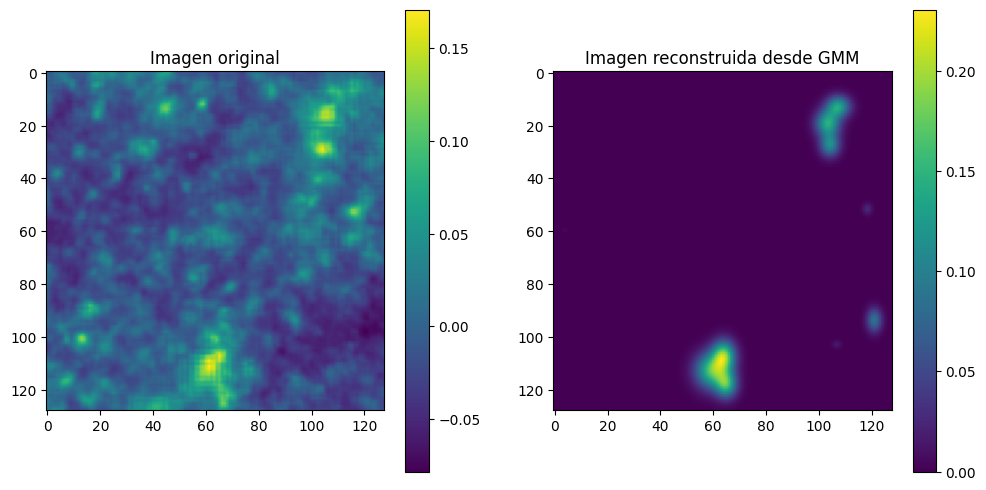

In [82]:
# Reconstruir la imagen a partir de las gaussianas
reconstructed_image = reconstruct_image_from_gmm(image.shape, means, covariances, weights)

# --- Mostrar la imagen original y la reconstruida ---
plt.figure(figsize=(12, 6))

# Imagen original
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='viridis')
plt.title("Imagen original")
plt.colorbar()

# Imagen reconstruida
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='viridis')
plt.title("Imagen reconstruida desde GMM")
plt.colorbar()

plt.show()

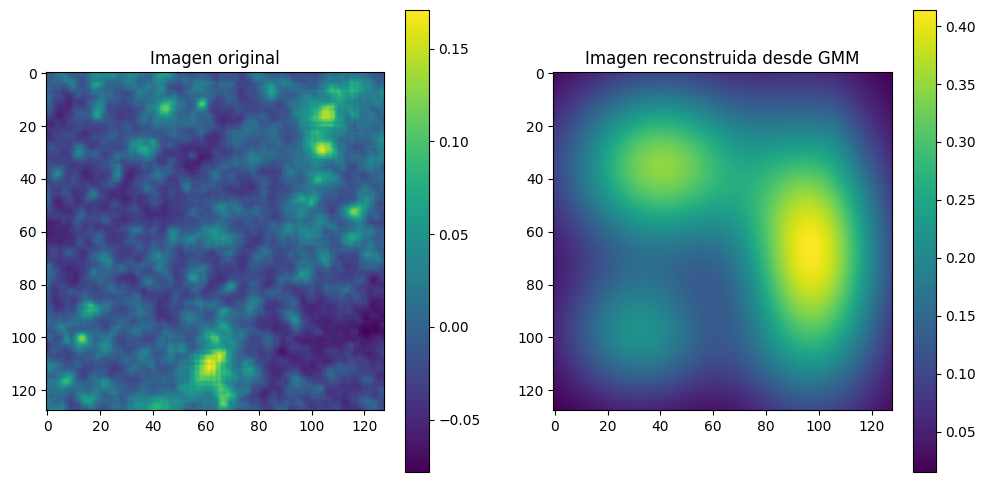

In [74]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_2d(x, y, mux, muy, sigma_x, sigma_y, weight):
    """Función que genera una gaussiana bidimensional."""
    return weight * np.exp(-((x - mux) ** 2 / (2 * sigma_x ** 2) + (y - muy) ** 2 / (2 * sigma_y ** 2)))

def reconstruct_image_from_gmm(image_shape, means, covariances, weights):
    """
    Reconstruye la imagen a partir de los parámetros del GMM.
    
    Parámetros:
        image_shape (tuple): La forma de la imagen (ancho, alto).
        means (numpy array): Medias de las gaussianas.
        covariances (numpy array): Covarianzas de las gaussianas.
        weights (numpy array): Pesos de mezcla de las gaussianas.
    
    Retorna:
        reconstructed_image (numpy array): La imagen reconstruida.
    """
    # Crear una cuadrícula de coordenadas
    x_grid, y_grid = np.meshgrid(np.arange(image_shape[0]), np.arange(image_shape[1]), indexing='ij')

    # Inicializar la imagen reconstruida
    reconstructed_image = np.zeros(image_shape)

    # Iterar sobre las gaussianas para reconstruir la imagen
    for i in range(len(means)):
        mux, muy, _ = means[i]  # Las coordenadas de la media (x, y)
        sigma_x, sigma_y = np.sqrt(covariances[i][0, 0]), np.sqrt(covariances[i][1, 1])  # Desviaciones estándar
        weight = weights[i]  # Peso de la gaussiana

        # Generar la gaussiana y añadirla a la imagen reconstruida
        gaussian = gaussian_2d(x_grid, y_grid, mux, muy, sigma_x, sigma_y, weight)
        reconstructed_image += gaussian

    return reconstructed_image



# Reconstruir la imagen a partir de las gaussianas
reconstructed_image = reconstruct_image_from_gmm(image.shape, means, covariances, weights)

# --- Mostrar la imagen original y la reconstruida ---
plt.figure(figsize=(12, 6))

# Imagen original
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='viridis')
plt.title("Imagen original")
plt.colorbar()

# Imagen reconstruida
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='viridis')
plt.title("Imagen reconstruida desde GMM")
plt.colorbar()

plt.show()
